In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style(style = 'ticks')
import warnings
import scipy.stats as stats
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv(os.path.join('data_set_final.csv'))

In [3]:
df['DATA_VENDA'] = pd.to_datetime(df['DATA_VENDA'])
df["ABERTURA_LOJA"] = pd.to_datetime(df["ABERTURA_LOJA"],format="%H:%M")
df["FECHO_LOJA"] = pd.to_datetime(df["FECHO_LOJA"],format="%H:%M")
df["TEMPO_ABERTURA"] = df["FECHO_LOJA"]-df["ABERTURA_LOJA"]
df["HORAS_ABERTURA"] = df["TEMPO_ABERTURA"].dt.total_seconds() / 3600

In [4]:
##Atibuir produtividade a produtivida_hora = 0
df.loc[(df['PRODUTIVIDADE_HORA'] == 0) & (df['LOJA'] == 'S - Vila Franca de Xira'), 'PRODUTIVIDADE_HORA'] = 149
df.loc[(df['PRODUTIVIDADE_HORA'] == 0) & (df['LOJA'] == 'S - Cacilhas'), 'PRODUTIVIDADE_HORA'] = 147
df.loc[(df['PRODUTIVIDADE_HORA'] == 0) & (df['LOJA'] == 'S - Ajuda'), 'PRODUTIVIDADE_HORA'] = 158


In [5]:
# Imputação
# Identify the first sales date for each store
first_sales_date = df.groupby('LOJA')['DATA_VENDA'].min().reset_index()

# Create a complete date range for each store starting from the first sales date
complete_data = pd.DataFrame()

for _, row in first_sales_date.iterrows():
    store = row['LOJA']
    start_date = row['DATA_VENDA']
    end_date = df['DATA_VENDA'].max()
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    store_data = pd.DataFrame({'LOJA': store, 'DATA_VENDA': all_dates})
    complete_data = pd.concat([complete_data, store_data])

# Merge the complete date range with the original data
data_set_final_complete = pd.merge(complete_data, df, on=['LOJA', 'DATA_VENDA'], how='left')

# Define the holiday dates and their respective names
holiday_names = {
    '2019-12-25': 'Dia de Natal',
    '2020-12-25': 'Dia de Natal',
    '2021-12-25': 'Dia de Natal',
    '2022-12-25': 'Dia de Natal',
    '2019-01-01': 'Dia Ano Novo',
    '2020-01-01': 'Dia Ano Novo',
    '2021-01-01': 'Dia Ano Novo',
    '2022-01-01': 'Dia Ano Novo',
    '2013-01-01': 'Dia Ano Novo'
}
holiday_dates = pd.to_datetime(list(holiday_names.keys()))

# Create a mask for holiday dates
holiday_mask = data_set_final_complete['DATA_VENDA'].isin(holiday_dates)

# Set the holiday and store_open columns for the specific holiday dates
data_set_final_complete.loc[holiday_mask, 'FERIADO_FIXO'] = 1
data_set_final_complete.loc[holiday_mask, 'ABERTURA_FERIADO'] = 0

# Set VALOR_VENDA and ITEMS to 0 for holidays where the store is closed
data_set_final_complete.loc[holiday_mask, ['VALOR_VENDA', 'ITEMS','SKUS_UP','SKUS_DOWN','AUMENTO_PRECO','DESCIDA_PRECO']] = 0

# Fill DATA_FERIADO with DATA_VENDA for holidays
data_set_final_complete.loc[holiday_mask, 'DATA_FERIADO'] = data_set_final_complete.loc[holiday_mask, 'DATA_VENDA']

# Fill TIPO_FERIADO with specific names for holidays
for date, name in holiday_names.items():
    mask_date = (data_set_final_complete['DATA_VENDA'] == pd.to_datetime(date))
    data_set_final_complete.loc[mask_date, 'TIPO_FERIADO'] = name

# Fill missing sales using the average of the last 4 values for the same day of the week
data_set_final_complete['day_of_week'] = data_set_final_complete['DATA_VENDA'].dt.dayofweek

def fill_with_rolling_avg(group):
    group = group.sort_values('DATA_VENDA')
    group['rolling_avg_sales'] = group['VALOR_VENDA'].rolling(window=4, min_periods=1).mean()
    group['VALOR_VENDA'] = group['VALOR_VENDA'].fillna(group['rolling_avg_sales'])
    group['rolling_avg_items'] = group['ITEMS'].rolling(window=4, min_periods=1).mean()
    group['ITEMS'] = group['ITEMS'].fillna(group['rolling_avg_items'])
    group['rolling_avg_SKUS_UP'] = group['SKUS_UP'].rolling(window=4, min_periods=1).mean()
    group['SKUS_UP'] = group['SKUS_UP'].fillna(group['rolling_avg_SKUS_UP'])
    group['rolling_avg_SKUS_DOWN'] = group['SKUS_DOWN'].rolling(window=4, min_periods=1).mean()
    group['SKUS_DOWN'] = group['SKUS_DOWN'].fillna(group['rolling_avg_SKUS_DOWN'])
    group['rolling_avg_AUMENTO_PRECO'] = group['AUMENTO_PRECO'].rolling(window=4, min_periods=1).mean()
    group['AUMENTO_PRECO'] = group['AUMENTO_PRECO'].fillna(group['rolling_avg_AUMENTO_PRECO'])
    group['rolling_avg_DESCIDA_PRECO'] = group['DESCIDA_PRECO'].rolling(window=4, min_periods=1).mean()
    group['DESCIDA_PRECO'] = group['DESCIDA_PRECO'].fillna(group['rolling_avg_DESCIDA_PRECO'])
    return group

# Apply the function to each store and day of the week
filled_data = data_set_final_complete.groupby(['LOJA', 'day_of_week']).apply(fill_with_rolling_avg)

# Reset index to avoid ambiguity
filled_data.reset_index(drop=True, inplace=True)

# Apply forward and backward fill to any remaining missing values for sales and items
filled_data['VALOR_VENDA'] = filled_data['VALOR_VENDA'].fillna(method='ffill').fillna(method='bfill')
filled_data['ITEMS'] = filled_data['ITEMS'].fillna(method='ffill').fillna(method='bfill')
filled_data['SKUS_UP'] = filled_data['SKUS_UP'].fillna(method='ffill').fillna(method='bfill')
filled_data['SKUS_DOWN'] = filled_data['SKUS_DOWN'].fillna(method='ffill').fillna(method='bfill')
filled_data['AUMENTO_PRECO'] = filled_data['AUMENTO_PRECO'].fillna(method='ffill').fillna(method='bfill')
filled_data['DESCIDA_PRECO'] = filled_data['DESCIDA_PRECO'].fillna(method='ffill').fillna(method='bfill')

# Sort the DataFrame by LOJA and DATA_VENDA
filled_data = filled_data.sort_values(by=['LOJA', 'DATA_VENDA'])

# Forward-fill and backward-fill the missing values for the other columns
columns_to_fill = ['LOJA_ID', 'CIDADE', 'REGIAO', 'ABERTURA_LOJA', 'FECHO_LOJA', "HORAS_ABERTURA","TEMPO_ABERTURA", "TOTAL_COLABORADORES","SKUS","CAIXAS_TRADICIONAIS","SELF_CHECKOUT", "PRODUTIVIDADE_HORA"
]
filled_data[columns_to_fill] = filled_data.groupby('LOJA')[columns_to_fill].fillna(method='ffill').fillna(method='bfill')
# Drop the helper columns if no longer needed
# filled_data.drop(columns=['day_of_week', 'rolling_avg'], inplace=True)


In [6]:
# Filtrar o dataset para ter o mesmo nr de meses
start_date = '2019-10-30'
end_date = '2023-10-30'
filtered_data = filled_data[(filled_data['DATA_VENDA'] >= start_date) & (filled_data['DATA_VENDA'] <= end_date)]


In [7]:
# Acrescentar media diária de venda por loja
filtered_data['VENDA_MEDIA_TOTAL'] = filtered_data.groupby(['LOJA_ID'])['VALOR_VENDA'].transform('mean')

In [8]:
#Acrescentar preco medio
filtered_data['PRECO_MEDIO'] = filtered_data['VALOR_VENDA']/filtered_data['ITEMS']

In [9]:
#filtered_data['PRECO_MEDIO'].isna().sum()

In [10]:
filtered_data['PRECO_MEDIO'].fillna(0, inplace=True)

In [11]:
#Acrescentar Mês
filtered_data['MES'] = filtered_data['DATA_VENDA'].dt.month

In [12]:
# Agregar por loja, mes, regiao e calcular medias
monthly_data_by_store = filtered_data.groupby(['LOJA_ID', 'REGIAO', 'MES', 'PRODUTIVIDADE_HORA', 'VENDA_MEDIA_TOTAL']).agg(VENDA_MEDIA_MENSAL = ('VALOR_VENDA', 'mean'),
     PRECO_MEDIO_MES = ('PRECO_MEDIO', 'mean'), VENDA_TOTAL = ('VALOR_VENDA', 'sum')
).reset_index()

In [13]:
#Features para o clustering  
features = monthly_data_by_store[['VENDA_MEDIA_MENSAL','VENDA_MEDIA_TOTAL' , 'PRODUTIVIDADE_HORA', 'PRECO_MEDIO_MES']]

In [14]:
# Normalização das  features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

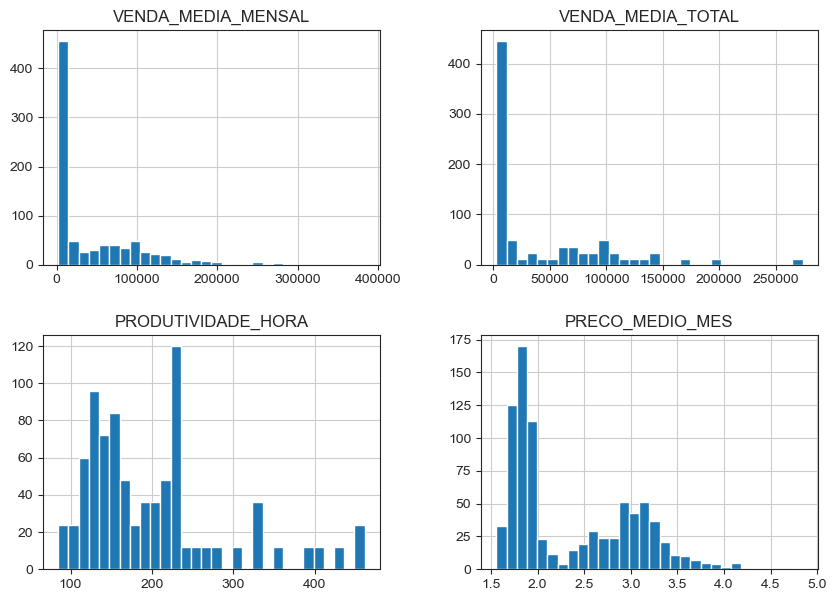

In [15]:
# Ver distribuição das features 
features[[ 'VENDA_MEDIA_MENSAL'   ,'VENDA_MEDIA_TOTAL'   ,   'PRODUTIVIDADE_HORA', 'PRECO_MEDIO_MES']].hist(bins=30, figsize=(10, 7))
plt.show()

In [16]:
# Determinar o numero otimo de clusters com Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

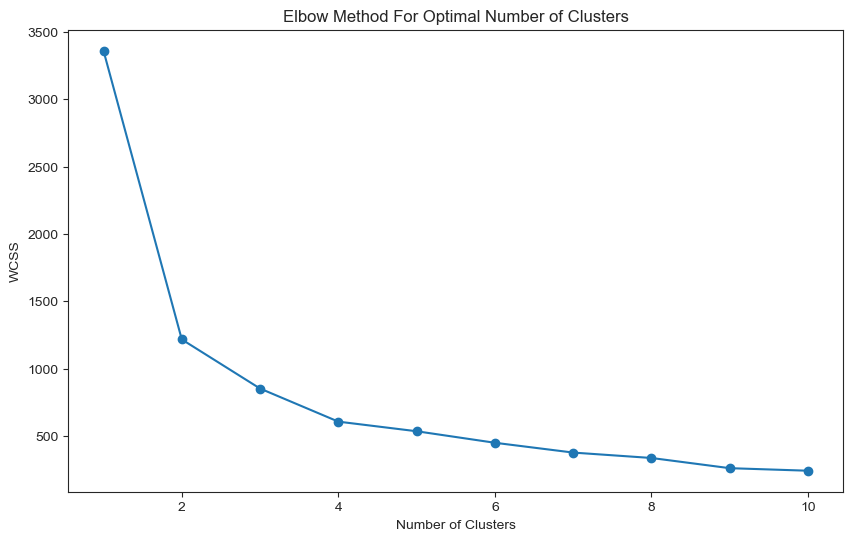

In [17]:
# Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [18]:
# K-Means clustering com 3 clusters
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
monthly_data_by_store['cluster'] = kmeans.fit_predict(features_scaled)

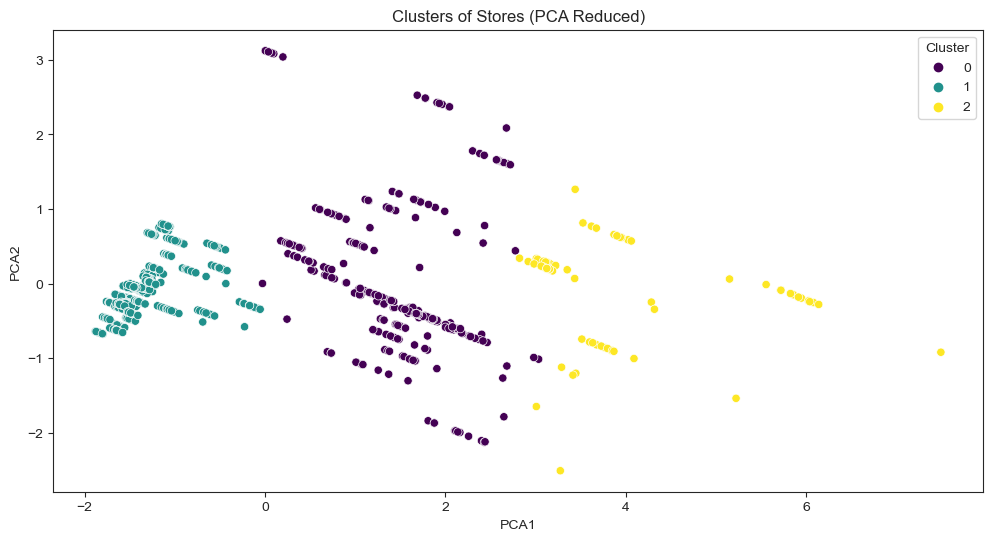

In [19]:
#PCA para visualaização
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)
monthly_data_by_store['PCA1'] = pca_result[:, 0]
monthly_data_by_store['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=monthly_data_by_store, palette='viridis')
plt.title('Clusters of Stores (PCA Reduced)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()



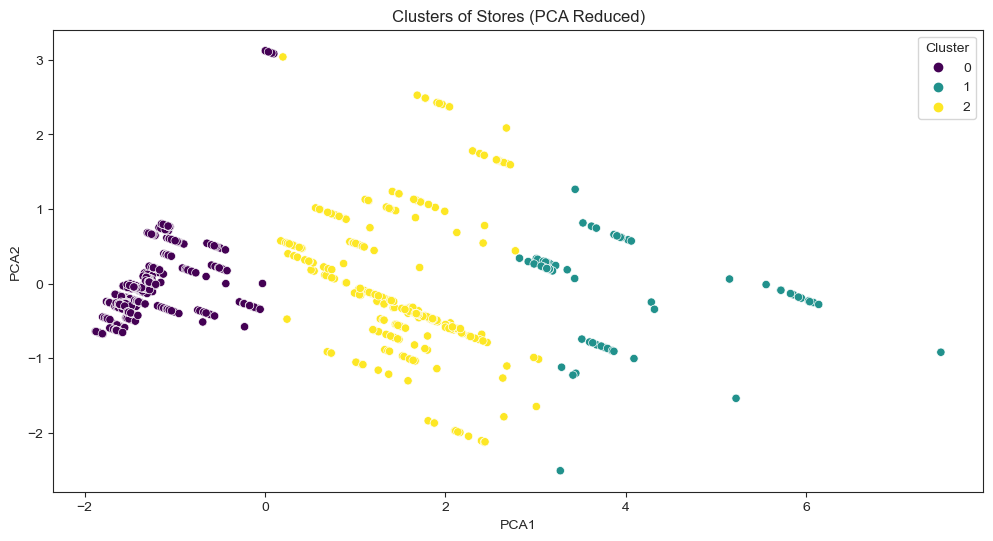

In [20]:

#2º run
# K-Means clustering com 3 clusters e 3 execuções
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters,n_init=3, random_state=42)
monthly_data_by_store['cluster_3'] = kmeans.fit_predict(features_scaled)


#PCA para visualaização
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)
monthly_data_by_store['PCA1'] = pca_result[:, 0]
monthly_data_by_store['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_3', data=monthly_data_by_store, palette='viridis')
plt.title('Clusters of Stores (PCA Reduced)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()


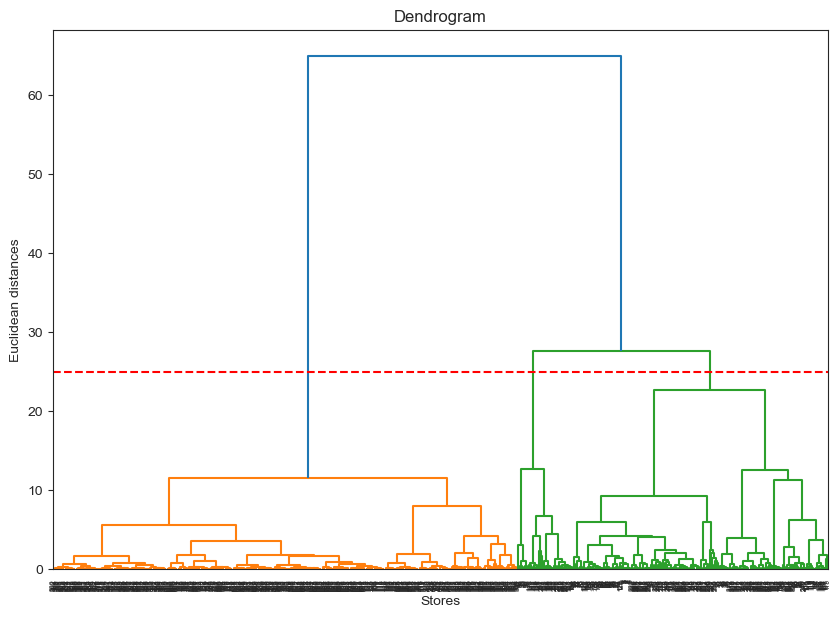

In [21]:
import scipy.cluster.hierarchy as sch

#Dendograma
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(features_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Stores')
plt.ylabel('Euclidean distances')

threshold = 25
plt.axhline(y=threshold, color='r', linestyle='--')
plt.show()



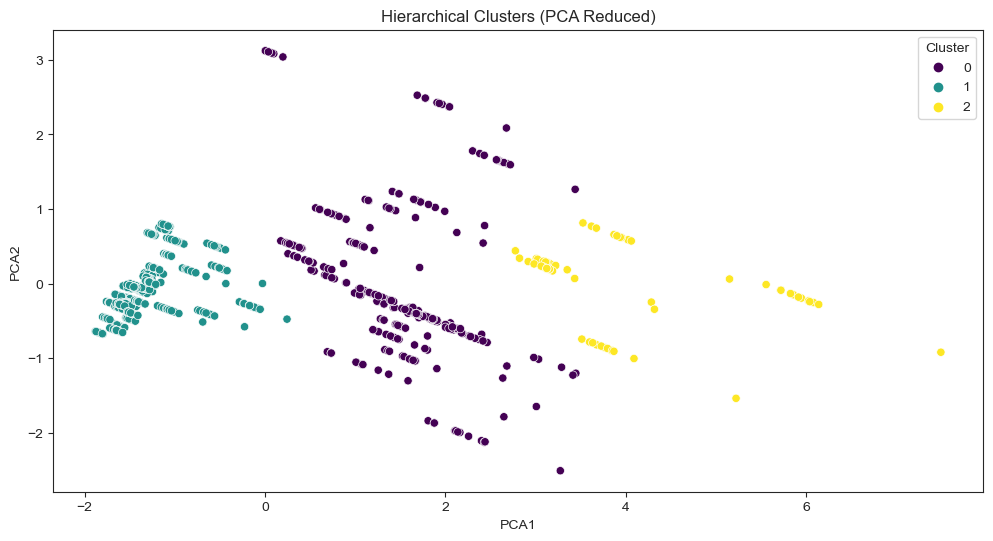

In [22]:
# Hierarchical clustering
from sklearn.cluster import AgglomerativeClustering

hierarchical_cluster = AgglomerativeClustering(n_clusters=3, linkage='ward', metric='euclidean')
monthly_data_by_store['hierarchical_cluster'] = hierarchical_cluster.fit_predict(features_scaled)


# PCA para visualização
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)
monthly_data_by_store['PCA1'] = pca_result[:, 0]
monthly_data_by_store['PCA2'] = pca_result[:, 1]


plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='hierarchical_cluster', data=monthly_data_by_store, palette='viridis')
plt.title('Hierarchical Clusters (PCA Reduced)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

In [23]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Fit a RandomForest to determine feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features_scaled, monthly_data_by_store['hierarchical_cluster'])

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': features.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance


,Feature,Importance
1,VENDA_MEDIA_TOTAL,0.519201
0,VENDA_MEDIA_MENSAL,0.321647
2,PRODUTIVIDADE_HORA,0.096351
3,PRECO_MEDIO_MES,0.062801


In [24]:
# RandomForest para  determinar feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features_scaled, monthly_data_by_store['cluster'])


feature_importance = pd.DataFrame({
    'Feature': features.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance

,Feature,Importance
1,VENDA_MEDIA_TOTAL,0.431483
0,VENDA_MEDIA_MENSAL,0.415685
2,PRODUTIVIDADE_HORA,0.082630
3,PRECO_MEDIO_MES,0.070202


In [25]:
from sklearn.metrics import silhouette_score
#Confirmação da robustez da estrutura através do silhouette score 

sil_score_hierarchical = silhouette_score(features_scaled, monthly_data_by_store['hierarchical_cluster'])
print(f'Silhouette Score for Hierarchical Clustering: {sil_score_hierarchical}')

sil_score_kmeans = silhouette_score(features_scaled, monthly_data_by_store['cluster'])
print(f'Silhouette Score for K-means Clustering: {sil_score_kmeans}')


Silhouette Score for Hierarchical Clustering: 0.607418875391539
Silhouette Score for K-means Clustering: 0.607670062620397


Nota <br>
0.71 - 1.00: Strong clustering structure /
0.51 - 0.70: Reasonable structure /
0.26 - 0.50: Weak structure /
< 0.25: No substantial structure /

In [26]:
monthly_data_by_store

,LOJA_ID,REGIAO,MES,PRODUTIVIDADE_HORA,VENDA_MEDIA_TOTAL,VENDA_MEDIA_MENSAL,PRECO_MEDIO_MES,VENDA_TOTAL,cluster,PCA1,PCA2,cluster_3,hierarchical_cluster
0,POR008,Porto,1,210.0,97727.563929,89203.817480,2.750614,1.097207e+07,0,1.279295,-0.472388,2,0
1,POR008,Porto,2,210.0,97727.563929,89378.321150,2.787846,1.009975e+07,0,1.309845,-0.485432,2,0
2,POR008,Porto,3,210.0,97727.563929,89341.988710,2.801965,1.107841e+07,0,1.320476,-0.489912,2,0
3,POR008,Porto,4,210.0,97727.563929,97341.962778,2.949043,1.168104e+07,0,1.509217,-0.574722,2,0
4,POR008,Porto,5,210.0,97727.563929,91777.692204,2.934678,1.138043e+07,0,1.446256,-0.544665,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,U0143,Lisboa Central,8,158.0,5723.570311,5391.027742,1.901708,6.684874e+05,1,-1.280020,0.019101,0,1
836,U0143,Lisboa Central,9,158.0,5723.570311,5712.212417,1.894087,6.854655e+05,1,-1.282951,0.020147,0,1
837,U0143,Lisboa Central,10,158.0,5723.570311,5871.844065,1.900151,7.222368e+05,1,-1.276754,0.017425,0,1
838,U0143,Lisboa Central,11,158.0,5723.570311,5519.519333,1.895246,4.967567e+05,1,-1.283844,0.020642,0,1


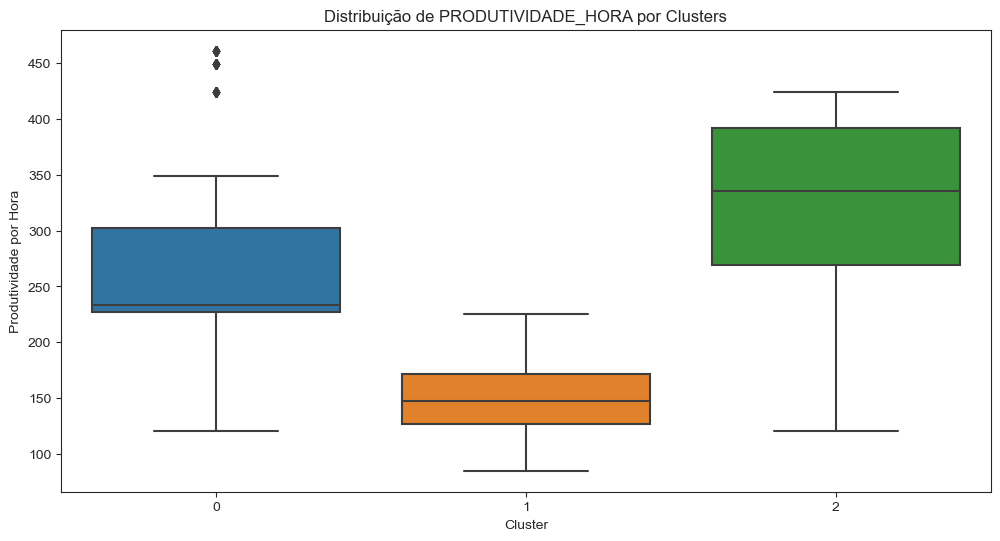

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='PRODUTIVIDADE_HORA', data=monthly_data_by_store)
plt.title('Distribuição de PRODUTIVIDADE_HORA por Clusters')
plt.xlabel('Cluster')
plt.ylabel('Produtividade por Hora')
plt.show()


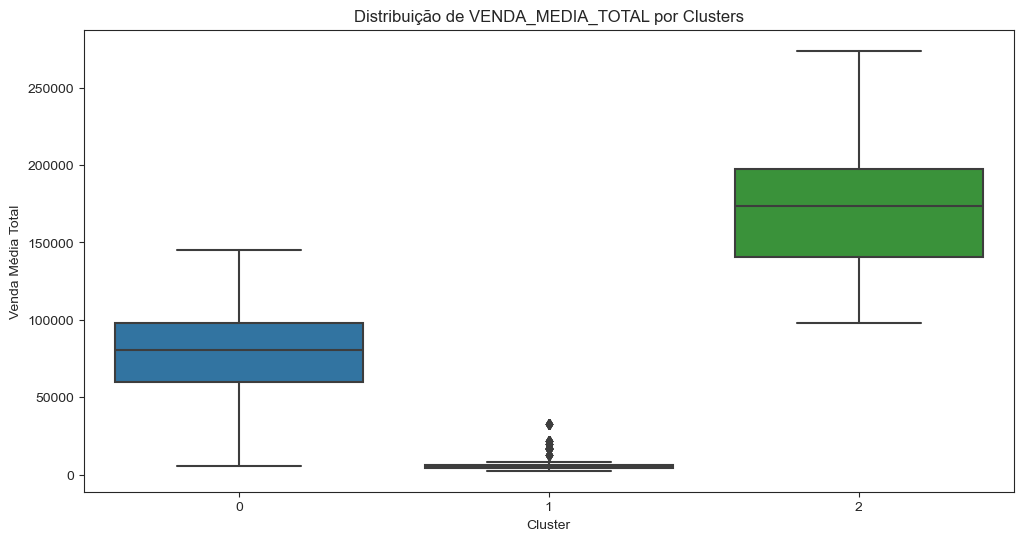

In [28]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='VENDA_MEDIA_TOTAL', data=monthly_data_by_store)
plt.title('Distribuição de VENDA_MEDIA_TOTAL por Clusters')
plt.xlabel('Cluster')
plt.ylabel('Venda Média Total')
plt.show()


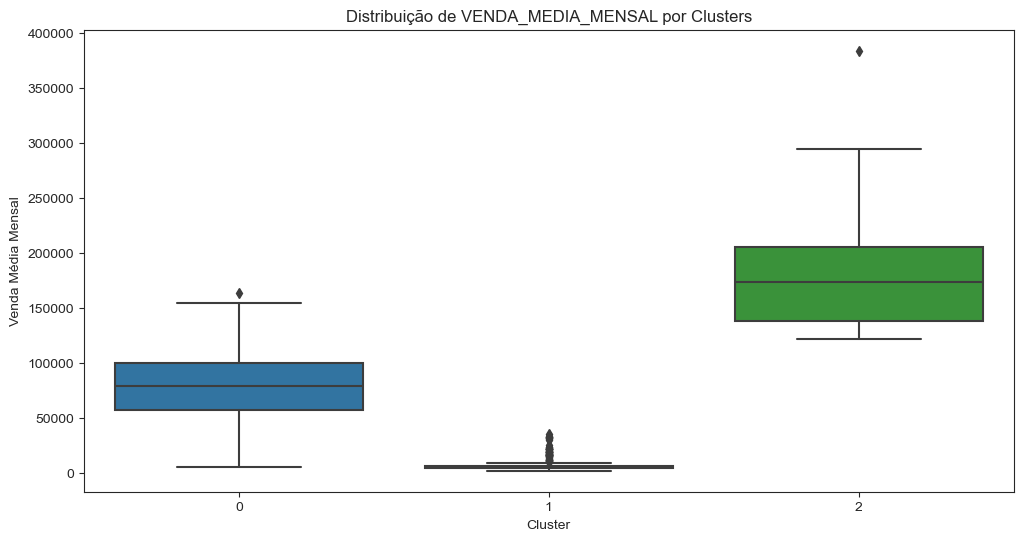

In [29]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='VENDA_MEDIA_MENSAL', data=monthly_data_by_store)
plt.title('Distribuição de VENDA_MEDIA_MENSAL por Clusters')
plt.xlabel('Cluster')
plt.ylabel('Venda Média Mensal')
plt.show()


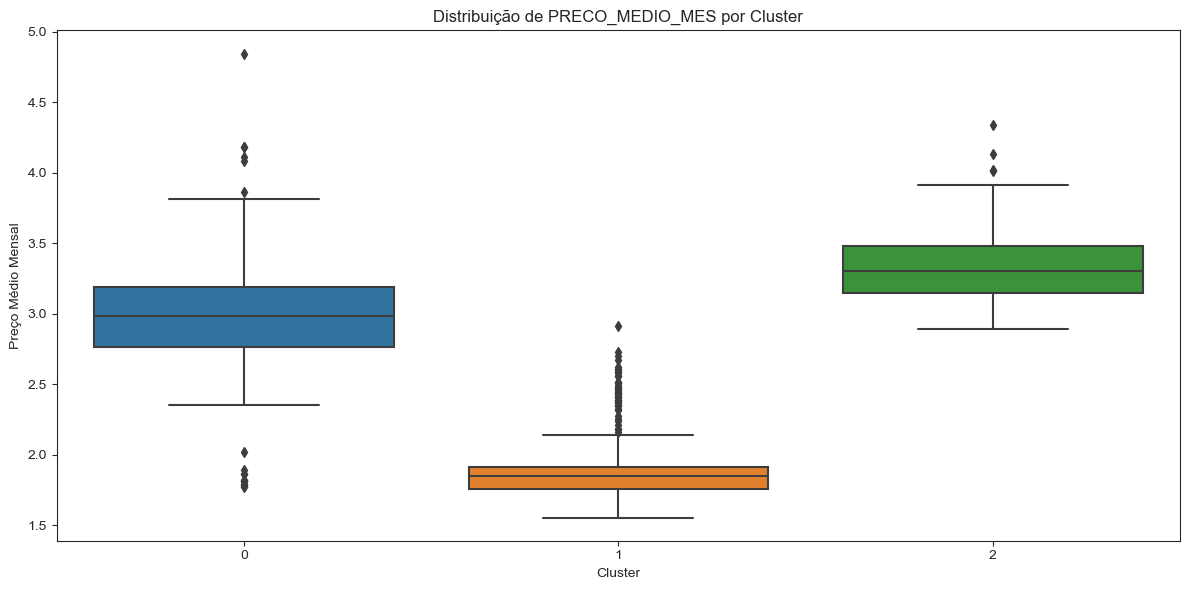

In [30]:
#Preço medio
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='PRECO_MEDIO_MES', data=monthly_data_by_store)

plt.title('Distribuição de PRECO_MEDIO_MES por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Preço Médio Mensal')

plt.tight_layout() 
plt.show()

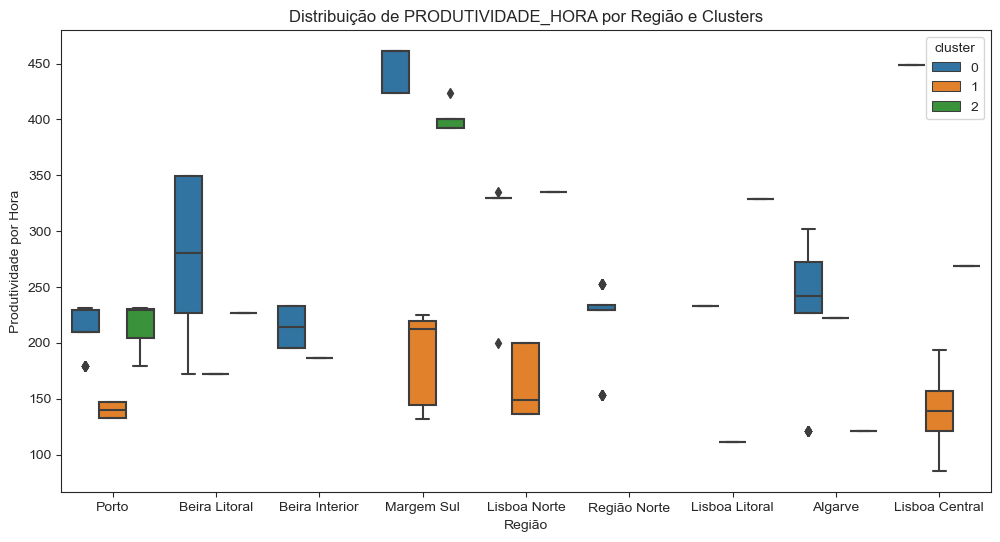

In [31]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='REGIAO', y='PRODUTIVIDADE_HORA', hue='cluster', data=monthly_data_by_store)
plt.title('Distribuição de PRODUTIVIDADE_HORA por Região e Clusters')
plt.xlabel('Região')
plt.ylabel('Produtividade por Hora')
plt.show()


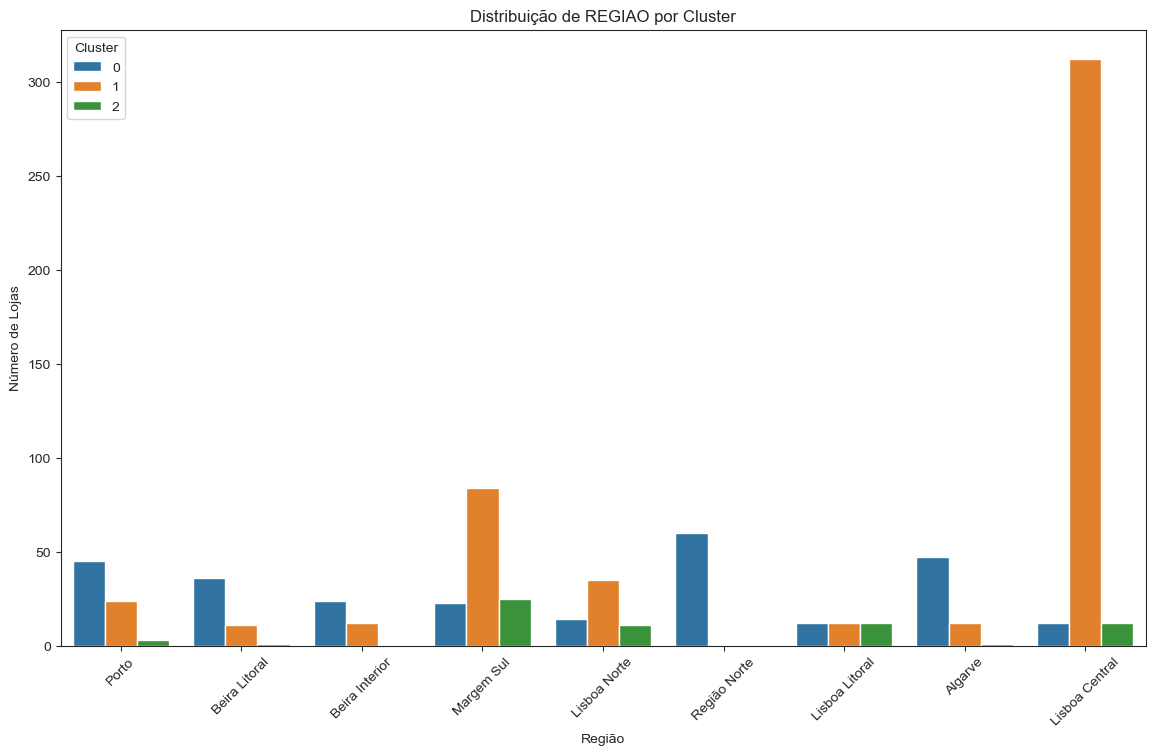

In [32]:
#Visualizar nr de lojas por cluster por regiao

plt.figure(figsize=(14, 8))
sns.countplot(data=monthly_data_by_store, x='REGIAO', hue='cluster')


plt.title('Distribuição de REGIAO por Cluster')
plt.xlabel('Região')
plt.ylabel('Número de Lojas')
plt.legend(title='Cluster')
plt.xticks(rotation=45)  

# Mostrar o gráfico
plt.show()


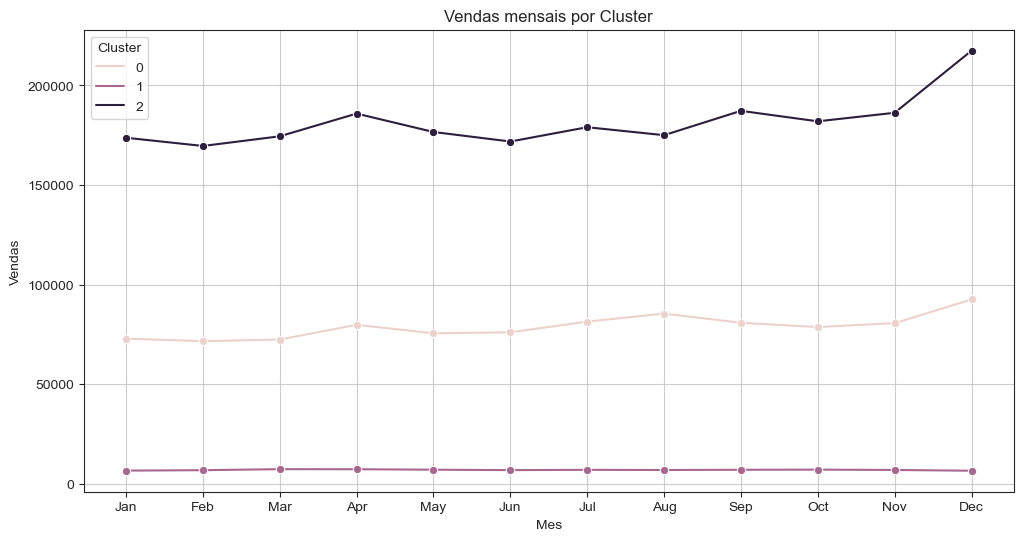

In [33]:
#Vendas medias mensais por Cluster

clustered_monthly_sales = monthly_data_by_store.groupby(['MES', 'cluster']).agg(
    total_sales=('VENDA_MEDIA_MENSAL', 'mean')
).reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(data=clustered_monthly_sales, x='MES', y='total_sales', hue='cluster', marker='o')


plt.title('Vendas mensais por Cluster')
plt.xlabel('Mes')
plt.ylabel('Vendas')
plt.legend(title='Cluster')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()


In [34]:
# Contar o número de lojas por cluster
contagem_clusters = monthly_data_by_store['cluster'].value_counts().reset_index()
contagem_clusters.columns = ['Cluster', 'Número de Lojas']

# Exibir a tabela de frequência
contagem_clusters

,Cluster,Número de Lojas
0,1,502
1,0,273
2,2,65


In [35]:
# Cluster 0
df_cluster_0 = monthly_data_by_store[monthly_data_by_store['cluster'] == 0]

tabela_frequencia = df_cluster_0['REGIAO'].value_counts().reset_index()
tabela_frequencia.columns = ['Região', 'Número de Lojas']

total_lojas = tabela_frequencia['Número de Lojas'].sum()

tabela_frequencia['Porcentagem (%)'] = (tabela_frequencia['Número de Lojas'] / total_lojas) * 100

tabela_frequencia = tabela_frequencia.sort_values(by='Número de Lojas', ascending=False)

tabela_frequencia

,Região,Número de Lojas,Porcentagem (%)
0,Região Norte,60,21.978022
1,Algarve,47,17.216117
2,Porto,45,16.483516
3,Beira Litoral,36,13.186813
4,Beira Interior,24,8.791209
5,Margem Sul,23,8.424908
6,Lisboa Norte,14,5.128205
7,Lisboa Litoral,12,4.395604
8,Lisboa Central,12,4.395604


In [36]:
#monthly_data_by_store.to_excel('monthly_data_by_store.xlsx', index=False)

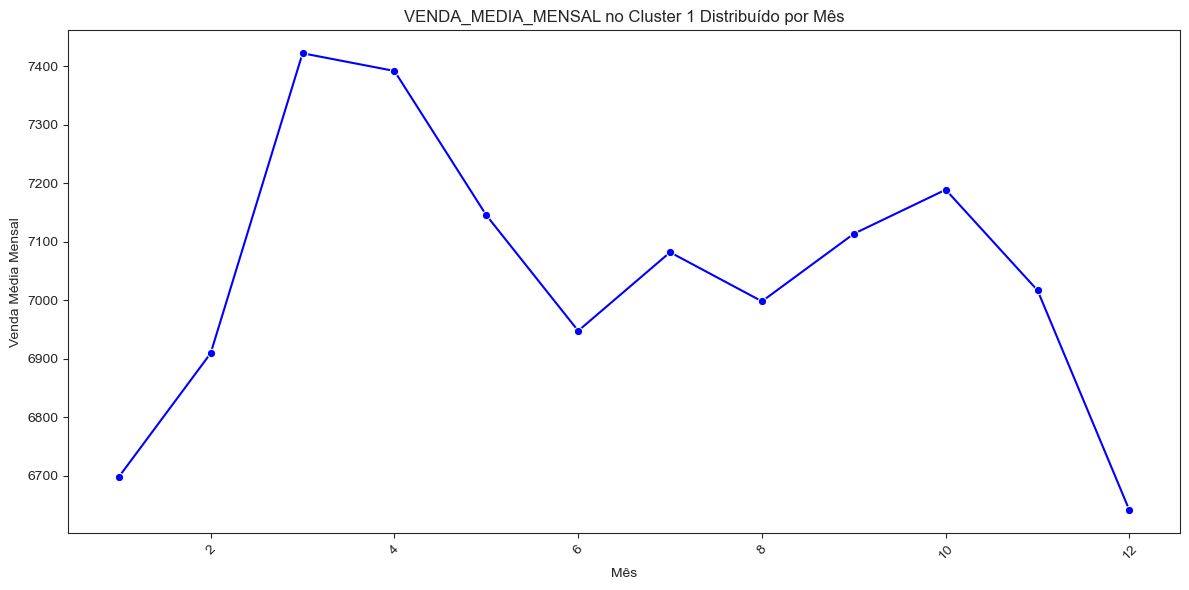

In [37]:
#Verificar Cluster 1
df_cluster_1 = monthly_data_by_store[monthly_data_by_store['cluster'] == 1]

df_mensal = df_cluster_1.groupby('MES')['VENDA_MEDIA_MENSAL'].mean().reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(x='MES', y='VENDA_MEDIA_MENSAL', data=df_mensal, marker='o', color='b')


plt.title('VENDA_MEDIA_MENSAL no Cluster 1 Distribuído por Mês')
plt.xlabel('Mês')
plt.ylabel('Venda Média Mensal')
plt.xticks(rotation=45)  # Rotacionar os rótulos do eixo x para melhor visualização

plt.tight_layout()  
plt.show()

#### Breves conclusões

Cluster 0 - Tem cerca de 270 lojas de todas as regiões, destacando-se a Região Norte com 60 e Algarve com 47. As vendas medias mensais variam entre 50 mil(€) e 100 mil(€), com ligeiro aumento em Agosto e Dezembro. <br>
Cluster 1 - Tem cerca de 500 lojas, 78% das mesmas situadas em Lisboa Central e Margem Sul. Apresenta uma distribuição de vandas mensais muito constante ao longo do ano, sem oscilações sazonais,embora claramente mais baixas do que os restantes clusters. A produtividade é também a mais baixa dos 3.  <br>
Cluster 2 - É o cluster mais pequeno em numero de lojas, com apenas 65. Tem a produtividade mais elevada, bem como, vendas mais elevadas em termos médios. A distribuição das vendas medias tem ligeiras oscilações ao longo dos meses, no entanto,  verifica-se um pico em Dezembro. 